# Sample Complexity Gap

This notebook aims to demonstrate the stated sample complexity gap in **Why Are Convolutional Networks More Sample Efficient Than Fully-Connected Nets? by Zhiyuan Li, Yi Zhang and Sanjeev Arora** [1]. We set up an experiment in which we should see the gap as an increasing polynomial curve of degree less than two.

## 1. Methods

For a given input dimension $d$, we seek the number $|S_{tr}|$ of training samples needed for a model to reach $\epsilon=0.9$ test accuracy. Then we plot the difference of training samples needed between a Convolutional Neural Network and a Fully Connected Neural Network for increasing values of $d$.

### Data

The inputs are $3\times k \times k$ RGB images for $k\in \mathbb{N}$, yielding input dimensions $d\in \{..., 192, 243, 300, 363, ...\}$. We create full training set of 10000 images and a test set of 10'000 and we ask "the first *how-many* training samples are needed to reach $90\%$ test accuracy if we train until convergence"? The training sets are constructed in the following manner.
+ Entry-wise independent Gaussian (mean 0, standard deviation 1)

We explore two different labelling functions 
\begin{equation}
h_1=\mathbb{1}[\sum_{i\in R} x_i > \sum_{i \in G}x_i] \quad\mathrm{ and }\quad h_2=\mathbb{1}[\sum_{i\in R} x_i^2 > \sum_{i \in G}x_i^2].
\end{equation}

### Models

1. 2-layer CNN
    + Convolution: One kernel per input channel of size 3x3, 10 output channels, stride size 1, and padding of 1, and bias
    + Activation function
    + Max pooling, kernel size 2x2, stride 2
    + Fully connected layer (160 in, 1 out) with bias
    + Sigmoid  
2. 2-layer "Dumb" CNN. (DCNN)
    + Convolution: One kernel per input channel of size 3x3, 2 output channels, stride size 1, and padding of 0, and bias
    + Activation function
    + Global average pooling, kernel size 8x8
    + Fully connected layer (160 in, 1 out) with bias
    + Sigmoid
2. 2-layer FCNN 
    + Fully connected layer (192 in, 3072 out) with bias
    + Activation function 
    + Fully connected layer (3072 in, 1 out) with bias
    + Sigmoid
    
We try both ReLU and Quadratic activation functions. 

### Training algorithm
+ Stochastic Gradient Descent with batch size 64
+ BCELoss
+ Learning rate $\gamma = 0.01$
+ Stopping criterion: At least 10 epochs AND Training loss < 0.01 AND Rolling avg. of rel. change in training loss < 0.01 (window size 10). OR 500 epochs.

### Model Evaluation
+ The model $M$ prediction is $\mathbb{1}[M(x)>0.5]$. Test accuracy is the percentage of correct predictions over the test set.

### Search algorithm

We seek the number of training samples needed to reach a fixed test accuracy using a kind of bisection algorithm.
1. Initial training run on 5000 samples.
    + If test accuracy > 0.9, take half step towards 0 -> 2'500
    + If test accuracy <= 0.9 take half step towards 10'000 -> 7500
2. Reload initial weights and retrain. Make quarter step.

This is repeated $10$ times with different weight initialisations in case the test-accuracy curves are not monotonically increasing due to noise.

In [7]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
ipython = get_ipython()

# New cell magic to use python variables in cell magic
@register_cell_magic
def format(line, cell):
    magic, program = line.split(' ')
    ipython.run_cell_magic(magic, program, cell.format(**globals()))

In [2]:
# Experiment variables
max_epochs      = 100 # Maximum number of training epochs per split
norm            = 2 # Labelling function parameter
accuracy        = 0.8 # Goal accuracy for convergence
delete_results  = True # Delete results of previous runs for that parameter set (all models).
filepath        = 'results/week2/p'+str(norm)+'_acc'+str(accuracy)+'_e'+str(max_epochs)+'.pkl' # Results file

In [9]:
%%format script powershell
python dim_vs_tr_size.py -min 4 -max 6 -f {filepath} -e {max_epochs} -p {norm} -acc {accuracy} -del {delete_results}

Windows PowerShell
Copyright (C) Microsoft Corporation. All rights reserved.

Try the new cross-platform PowerShell https://aka.ms/pscore6

PS C:\Users\oilio\Documents\School Documents\EPFL\MA3\Semester Project\Tasks> python week2.py -min 4 -max 6 -f results/week2/p2_acc0.8_e100.pkl -e 100 -p 2 -acc 0.8 -del True
Using device:  cpu 

----------------------------------------------------------------.0% Complete
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 48]               0
            Linear-2                 [-1, 3072]         150,528
              ReLU-3                 [-1, 3072]               0
            Linear-4                    [-1, 1]           3,073
           Sigmoid-5                    [-1, 1]               0
Total params: 153,601
Trainable params: 153,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params

## 3. Results

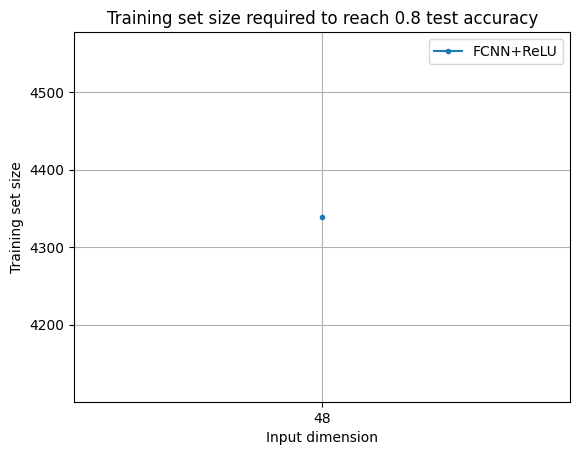

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open(filepath, 'rb') as file:
    sample_complexity = pickle.load(file)


# Extract data to plot
names = set([name for name, _ in sample_complexity.keys()])

# For every model, make line plot
for i, name in enumerate(names):
    x, y = list(zip(*sorted([(dim, tr_size) for (_name, dim), tr_size  in sample_complexity.items() if name == _name])))
    plt.plot(x, y, marker='.', linestyle='-', label=name)
    
# Plot graphics
plt.xlabel('Input dimension')
plt.ylabel('Training set size')
plt.title(f'Training set size required to reach {accuracy} test accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

1. [Why Are Convolutional Nets More Sample-Efficient than Fully-Connected Nets?](https://arxiv.org/abs/2010.08515) Zhiyuan Li, Yi Zhang, Sanjeev Arora, 2021